In [1]:
from __future__ import annotations

from typing import List

In [2]:
import platform

import cpuinfo
import psutil

with open("../ood-detection/system.tex", "w") as file:
    print("All tests were performed on a ", end="", file=file)

    uname = platform.uname()
    print(f"{uname.system} ({uname.release})".replace("_", r"\_"), end="", file=file)
    print(" machine with an ", end="", file=file)
    print(
        f"{cpuinfo.get_cpu_info()['brand_raw']} ({uname.processor})".replace(
            "_", r"\_",
        ), end="", file=file,
    )

    print(" processor with ", end="", file=file)

    print(f"{psutil.cpu_count(logical=False)} physical and ", end="", file=file)
    print(f"{psutil.cpu_count(logical=True)} total CPU cores ", end="", file=file)

    svmem = psutil.virtual_memory()
    print(f"and {svmem.total/(1024*1024*1024):.2f}GiB of RAM.", file=file)

In [3]:
import matplotlib as mpl
import numpy as np
import sklearn

from matplotlib import pyplot as plt

from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import OneClassSVM

from sklearn.metrics import roc_auc_score

In [4]:
import colorcet

conf_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'confidence_cmap', colorcet.m_CET_L20(np.linspace(0, 1.0/1.2, 1000)),
)

In [5]:
import phepy

from phepy.detector import OutOfDistributionDetector, PercentileScorer
from phepy.plot import plot_all_toy_examples
from phepy.toys import ToyExample
from phepy.toys.line import LineToyExample
from phepy.toys.circle import CircleToyExample
from phepy.toys.haystack import HaystackToyExample

In [6]:
line = LineToyExample(np.random.default_rng(42), N=10_000)
circle = CircleToyExample(np.random.default_rng(42), N=10_000)
haystack = HaystackToyExample(np.random.default_rng(42), N=10_000)

In [7]:
scores = []

def collect_detector_scores(scorer, toy, evaluation, ax):
    TP = np.sum(evaluation.confidence * evaluation.expected)
    FP = np.sum(evaluation.confidence * (1 - evaluation.expected))
    # TN = np.sum((1 - evaluation.confidence) * (1 - evaluation.expected))
    FN = np.sum((1 - evaluation.confidence) * evaluation.expected)

    precision = TP / (TP + FP)
    f1 = 2 * TP / (2 * TP + FP + FN)
    roc = roc_auc_score(evaluation.expected, evaluation.confidence)
    
    scores.append([
        type(scorer.detector), type(toy),
        precision, f1, roc, evaluation.fit_time,
        evaluation.predict_time, evaluation.detector_size,
    ])

In [8]:
class OneOptimalDetector(OutOfDistributionDetector):
    def __init__(self, toys: List[ToyExample]) -> OneOptimalDetector:
        self.__toys = toys
    
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False
    
    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> OneOptimalDetector:
        
        for toy in self.__toys:
            if X_train.shape != toy.X_train.shape:
                continue
            
            if np.all(X_train == toy.X_train):
                self.__toy = toy
                return self
        
        raise KeyError("unknown toy example")

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum((self.__toy.reconstruct(X_test) - X_test)**2, axis=1)

In [9]:
class OneClassSupportVectorMachineDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return True

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> OneClassSupportVectorMachineDetector:
        self.__X_svm = OneClassSVM(kernel="rbf").fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_svm.score_samples(X_test)

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)


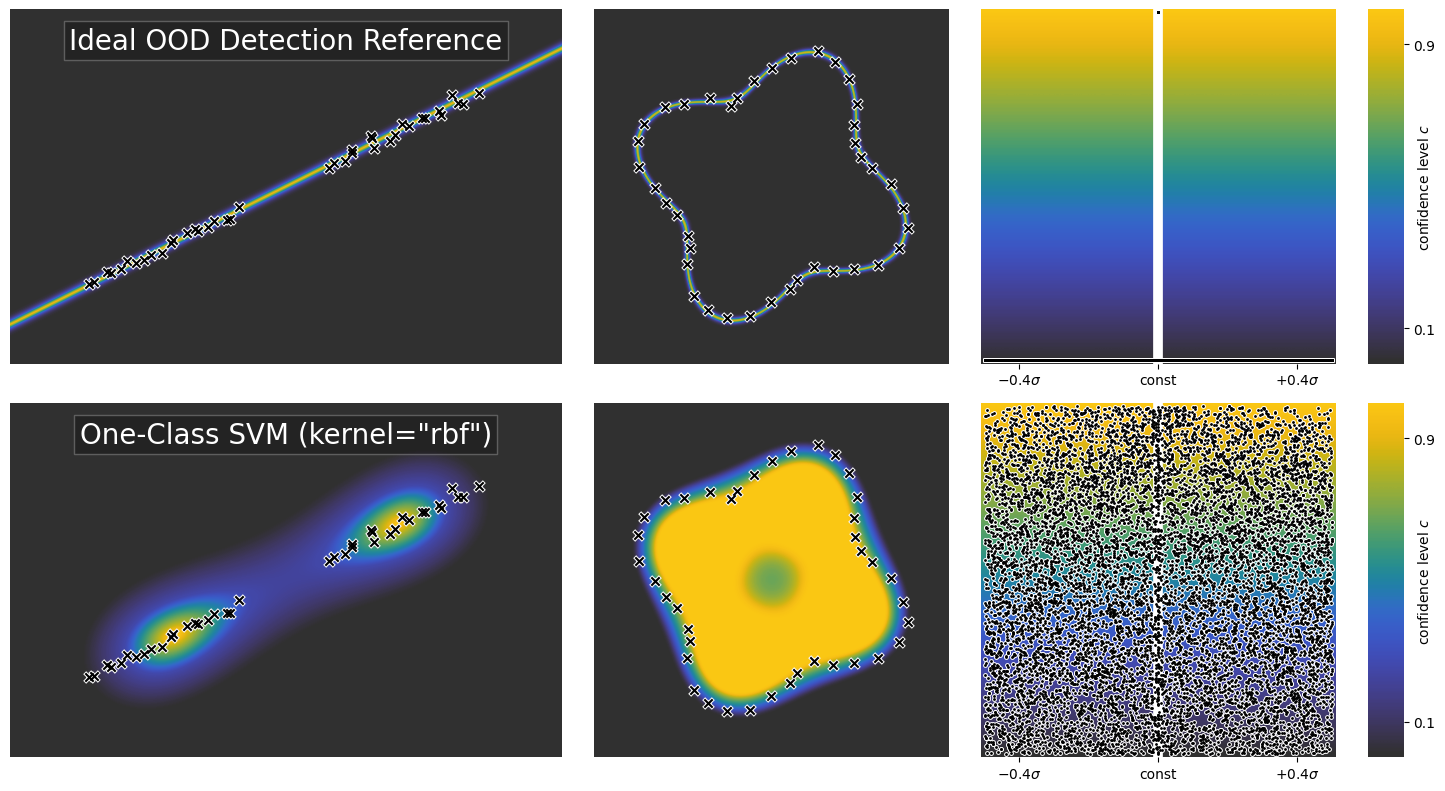

In [10]:
fig = plot_all_toy_examples(
    scorers = {
        "Ideal OOD Detection Reference": PercentileScorer(OneOptimalDetector([line, circle, haystack])),
        "One-Class SVM (kernel=\"rbf\")": PercentileScorer(OneClassSupportVectorMachineDetector()),
    },
    toys = [line, circle, haystack],
    cmap = conf_cmap,
    with_scorer = collect_detector_scores,
)

plt.savefig(
    "../ood-detection/figures/ood-detection/ood-detection-ideal-svm.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [11]:
class MahalanobisDistanceDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> MahalanobisDistanceDetector:
        self.__X_cov = EmpiricalCovariance().fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_cov.mahalanobis(X_test)

In [12]:
class LocalOutlierFactorDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return True

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> LocalOutlierFactorDetector:
        self.__X_lof = LocalOutlierFactor(novelty=True).fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_lof.score_samples(X_test)

In [13]:
class CoarseGaussianProcessDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> CoarseGaussianProcessDetector:
        rng = np.random.default_rng(seed=24)
        
        # Subsample to only include 10% of the training data
        I_train = rng.choice(len(X_train), size=len(X_train)//10, replace=False)
        
        self.__X_gp = GaussianProcessRegressor(kernel=RBF()+WhiteKernel()).fit(
            X_train[I_train], Y_train[I_train],
        )
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_gp.predict(X_test, return_std=True)[1]

In [14]:
class CoarseNoiseContrastiveGaussianProcessDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> CoarseNoiseContrastiveGaussianProcessDetector:
        rng = np.random.default_rng(seed=24)
        
        # Subsample to only include 5% of the training data
        I_train = rng.choice(len(X_train), size=len(X_train)//20, replace=False)
        
        X_train_noise = rng.normal(loc=X_train, scale=np.std(X_train, axis=0) + 1)
        Y_train_noise = rng.normal(loc=Y_train, scale=np.std(Y_train, axis=0) + 1)
        
        self.__X_gp_nc = GaussianProcessRegressor(kernel=RBF()+WhiteKernel()).fit(
            np.concatenate([X_train[I_train], X_train_noise[I_train]]),
            np.concatenate([Y_train[I_train], Y_train_noise[I_train]]),
        )
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_gp_nc.predict(X_test, return_std=True)[1]

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encoun

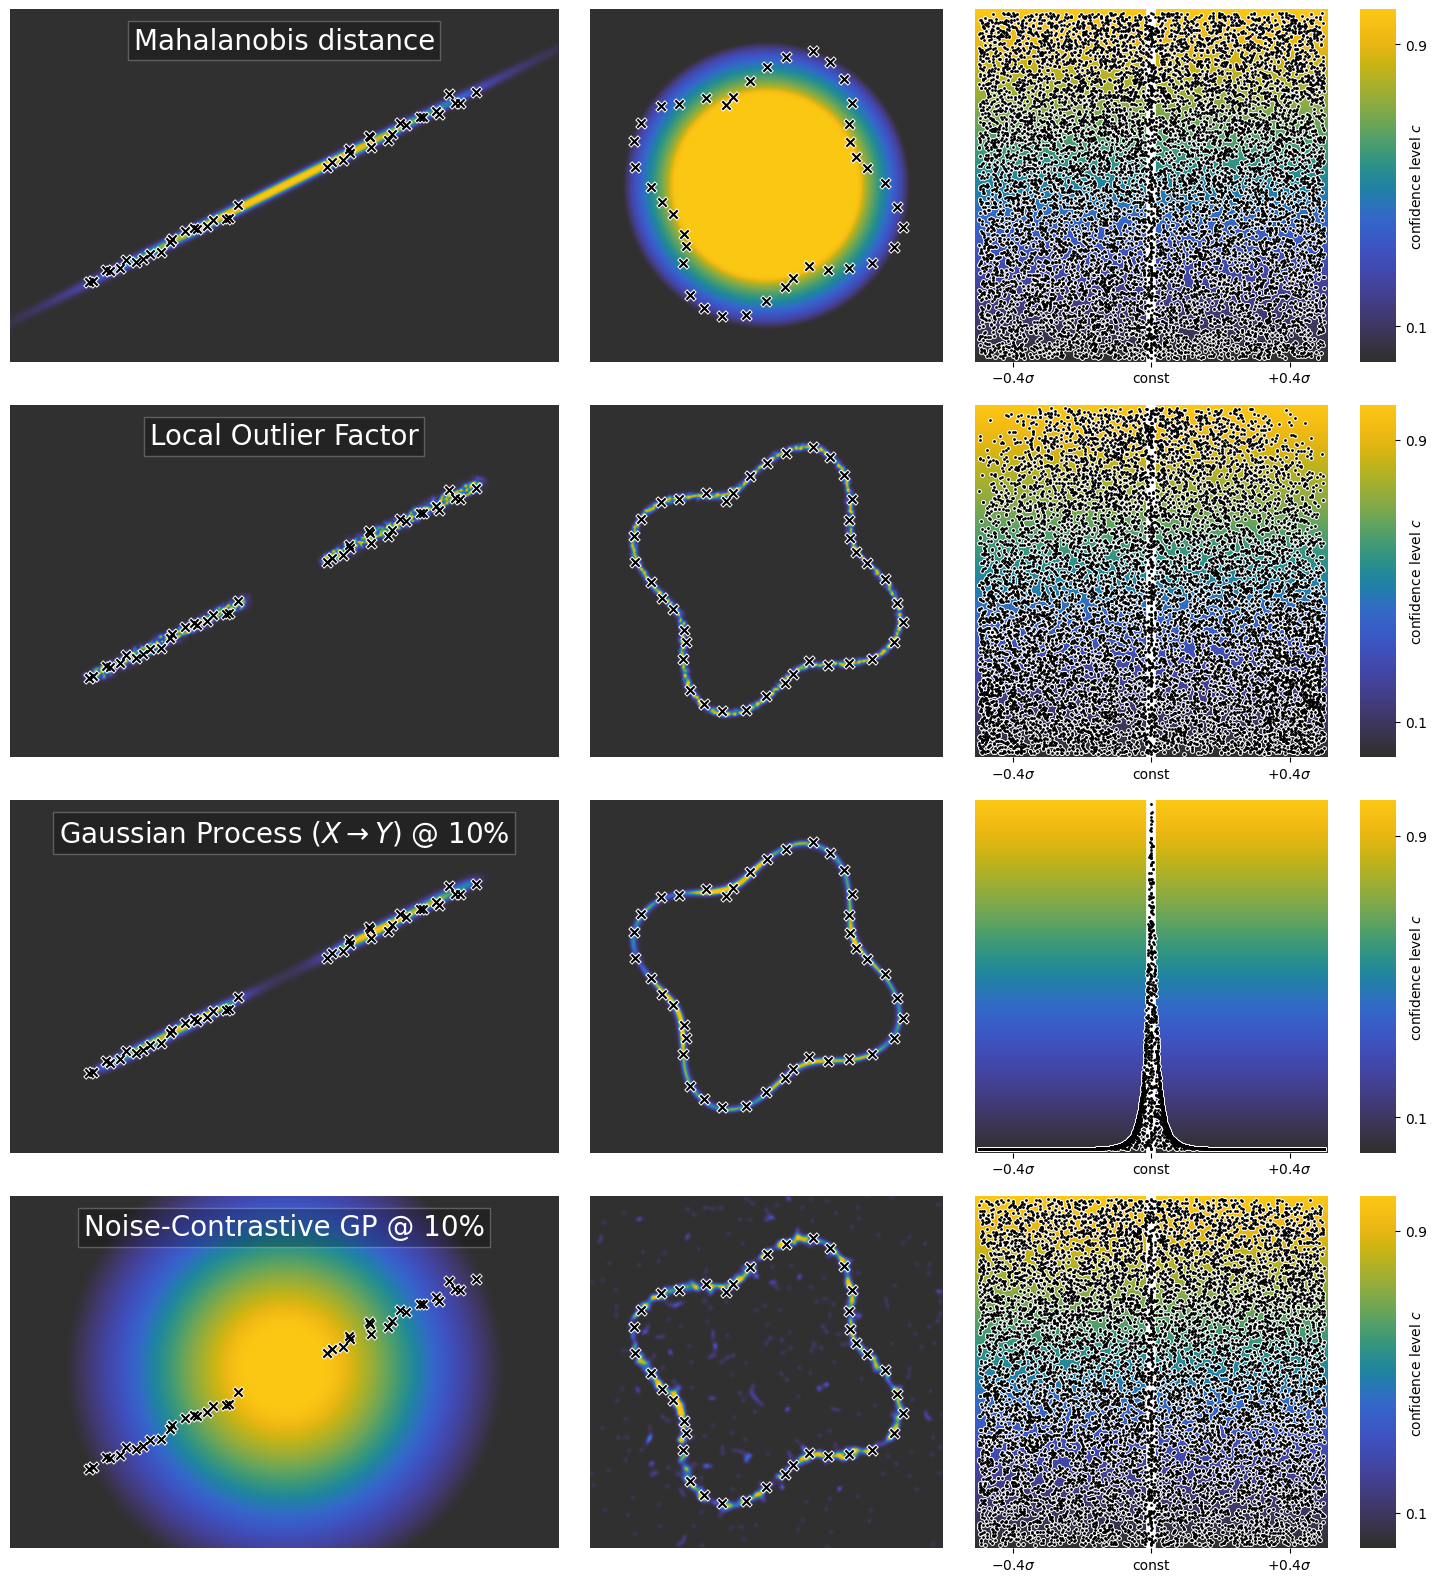

In [15]:
fig = plot_all_toy_examples(
    scorers = {
        "Mahalanobis distance": PercentileScorer(MahalanobisDistanceDetector()),
        "Local Outlier Factor": PercentileScorer(LocalOutlierFactorDetector()),
        r"Gaussian Process ($X \rightarrow Y$) @ 10%": PercentileScorer(CoarseGaussianProcessDetector()),
        "Noise-Contrastive GP @ 10%": PercentileScorer(CoarseNoiseContrastiveGaussianProcessDetector()),
    },
    toys = [line, circle, haystack],
    cmap = conf_cmap,
    with_scorer = collect_detector_scores,
)

plt.savefig(
    "../ood-detection/figures/ood-detection/ood-detection-md-lof-gp-nc.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [16]:
class TruncatedPrincipalComponentsDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> TruncatedPrincipalComponentsDetector:
        if X_train.shape[1] > 2:
            n_components = 0.95
        else:
            n_components = 1
        
        self.__X_pca = PCA(n_components=n_components, random_state=42).fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum((
            self.__X_pca.inverse_transform(self.__X_pca.transform(X_test)) - X_test
        )**2, axis=1)

In [17]:
class AutoAssociativeSigmoidDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> AutoAssociativeSigmoidDetector:
        self.__X_mlp = MLPRegressor(
            hidden_layer_sizes=[16, 1, 16],
            activation="logistic",
            solver="adam",
            max_iter=5000,
            random_state=42,
        ).fit(X_train, X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum((
            self.__X_mlp.predict(X_test) - X_test
        )**2, axis=1)

In [18]:
class AutoAssociativeSigmoidMahalanobisDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> AutoAssociativeSigmoidMahalanobisDetector:
        self.__X_mlp = MLPRegressor(
            hidden_layer_sizes=[16, 1, 16],
            activation="logistic",
            solver="adam",
            max_iter=5000,
            random_state=42,
        ).fit(X_train, X_train)
        self.__X_cov = EmpiricalCovariance().fit(
            self.__X_mlp.predict(X_train) - X_train
        )
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_cov.mahalanobis(
            self.__X_mlp.predict(X_test) - X_test
        )

In [19]:
class CoarseAutoAssociativeGaussianProcessDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> CoarseAutoAssociativeGaussianProcessDetector:
        rng = np.random.default_rng(seed=24)
        
        # Subsample to only include 1% of the training data
        I_train = rng.choice(len(X_train), size=len(X_train)//100, replace=False)
        
        self.__X_gp = GaussianProcessRegressor(kernel=RBF()+WhiteKernel()).fit(
            X_train[I_train], X_train[I_train],
        )
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum(self.__X_gp.predict(X_test, return_std=True)[1], axis=1)

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal valu

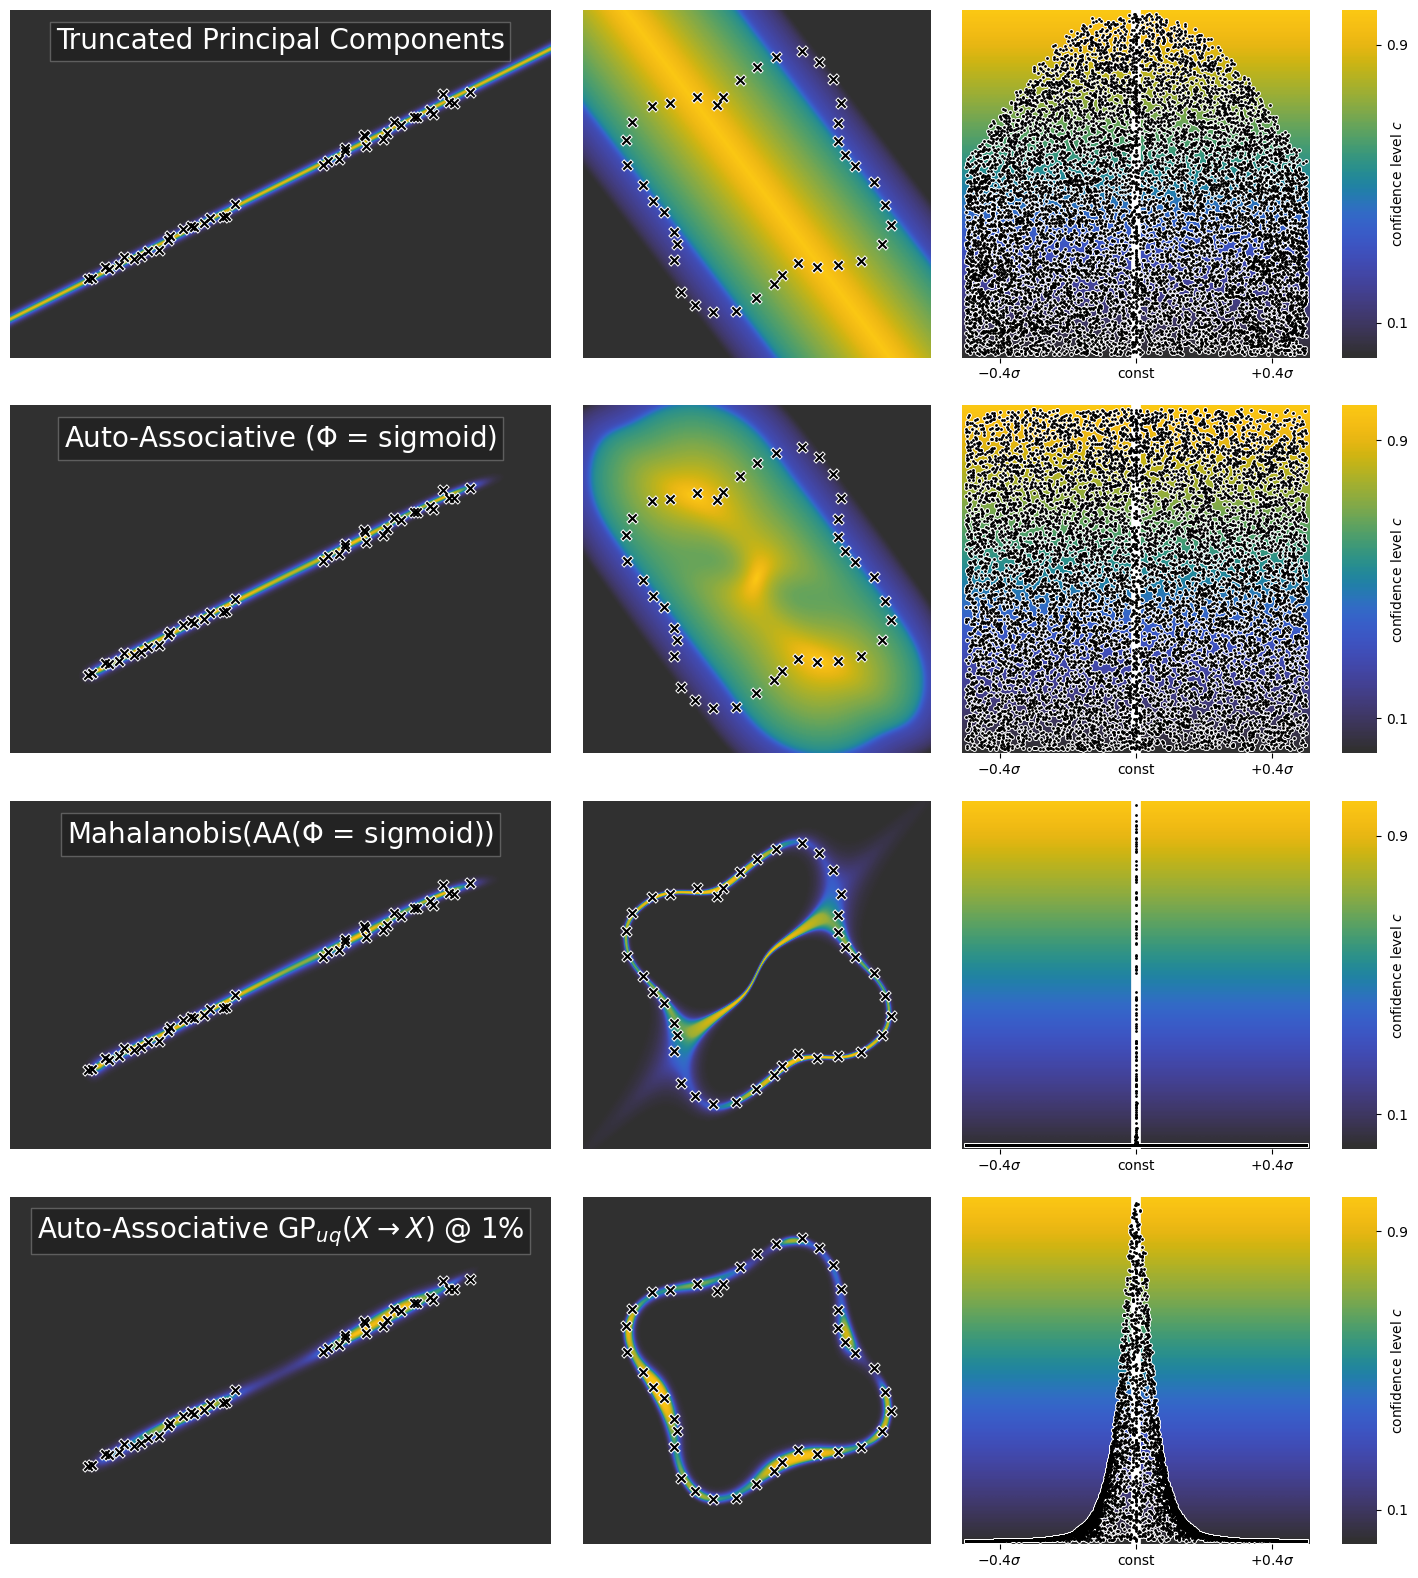

In [20]:
fig = plot_all_toy_examples(
    scorers = {
        "Truncated Principal Components": PercentileScorer(TruncatedPrincipalComponentsDetector()),
        "Auto-Associative ($\Phi$ = sigmoid)": PercentileScorer(AutoAssociativeSigmoidDetector()),
        "Mahalanobis(AA($\Phi$ = sigmoid))": PercentileScorer(AutoAssociativeSigmoidMahalanobisDetector()),
        r"Auto-Associative GP$_{uq}$($X \rightarrow X$) @ 1%": PercentileScorer(CoarseAutoAssociativeGaussianProcessDetector()),
    },
    toys = [line, circle, haystack],
    cmap = conf_cmap,
    with_scorer = collect_detector_scores,
)

plt.savefig(
    "../ood-detection/figures/ood-detection/ood-detection-pca-aa-maa-aagp.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [21]:
detector_abbreviations = {
    OneOptimalDetector: r"\Fref{fig:ideal-svm-ood-detection}{a} Reference",
    OneClassSupportVectorMachineDetector: r"\Fref{fig:ideal-svm-ood-detection}{b} 1c-SVM",
    MahalanobisDistanceDetector: r"\Fref{fig:md-lof-gp-nc-ood-detection}{a} MD",
    LocalOutlierFactorDetector: r"\Fref{fig:md-lof-gp-nc-ood-detection}{b} LOF",
    CoarseGaussianProcessDetector: r"\Fref{fig:md-lof-gp-nc-ood-detection}{c} GP @10\%",
    CoarseNoiseContrastiveGaussianProcessDetector: r"\Fref{fig:md-lof-gp-nc-ood-detection}{d} nc-GP @10\%",
    TruncatedPrincipalComponentsDetector: r"\Fref{fig:aa-ood-detection}{a} PCA-trunc.",
    AutoAssociativeSigmoidDetector: r"\Fref{fig:aa-ood-detection}{b} Auto-Assoc.",
    AutoAssociativeSigmoidMahalanobisDetector: r"\Fref{fig:aa-ood-detection}{c} MD(AA)",
    CoarseAutoAssociativeGaussianProcessDetector: r"\Fref{fig:aa-ood-detection}{d} AA-GP @1\%",
}

score_formatters = [
    lambda precision: str(np.round(precision, 3)),
    lambda f1_score: str(np.round(f1_score, 3)),
    lambda roc_auc: str(np.round(roc_auc, 3)),
    lambda fitting_time: str(
        np.round(fitting_time, 2)
        if fitting_time < 10.0 else
        np.round(fitting_time, 1)
        if fitting_time < 100.0 else
        int(np.round(fitting_time, 0))
        if fitting_time < 1000.0 else
        f"{int(np.round(fitting_time/1000, 0))}e3"
    ),
    lambda scoring_time: str(
        np.round(scoring_time, 2)
        if scoring_time < 10.0 else
        np.round(scoring_time, 1)
        if scoring_time < 100.0 else
        int(np.round(scoring_time, 0))
        if scoring_time < 1000.0 else
        f"{int(np.round(scoring_time/1000, 0))}e3"
    ),
    lambda memory: str(
        np.round(memory / 1024, 2)
        if memory < 10024 else
        np.round(memory / 1024, 1)
        if memory < 100024 else
        int(np.round(memory / 1024, 0))
        if memory < 1000024 else
        f"{int(np.round(memory / (1024*1024), 0))}e3"
    ),
]

with open("../ood-detection/tables/ood-detection.tex", "w") as table:
    print(r"\begin{tabular}{@{}ccccccc@{}}", file=table)
    print(r"    \toprule", file=table)
    print("    " + " & ".join([
        "OOD Detector", "Precision", "F$_1$ Score", "ROC-AUC",
        "Fitting Time [s]", "Scoring Time [s]", "Memory [kiB]",
    ]) + r"\\", file=table)
    print("    " + " & ".join(
        ["Toy Example"] + [r"L / C / H"] * 6
    ) + r"\\ \midrule", file=table)
    
    for i in range(0, len(scores), 3):
        detector_l, toy_l, *scores_l = scores[i+0]
        detector_c, toy_c, *scores_c = scores[i+1]
        detector_h, toy_h, *scores_h = scores[i+2]
        
        assert detector_l == detector_c == detector_h
        assert toy_l == LineToyExample
        assert toy_c == CircleToyExample
        assert toy_h == HaystackToyExample
        
        print("    ", end="", file=table)
        print(detector_abbreviations[detector_l], end="", file=table)
        
        if detector_l == OneOptimalDetector:
            # special case: reference detector only has relevant detection performance
            scores_l = scores_l[:3]
        
        for fmt, s_l, s_c, s_h in zip(score_formatters, scores_l, scores_c, scores_h):
            print(f" & {fmt(s_l)} / {fmt(s_c)} / {fmt(s_h)}", end="", file=table)
        
        if detector_l == OneOptimalDetector:
            # special case: reference detector does not have time or memory performance
            print(" & -" * 3, end="", file=table)
        
        print(r" \\", file=table)
    
    print(r"    \bottomrule", file=table)
    print(r"\end{tabular}", file=table)